In [1]:
import numpy as np
from legate.timing import time
import cunumeric as cu
import scipy as sc
import pyfftw
from tqdm import tqdm
import matplotlib.pyplot as plt
# Set random seed for reproducibility
np.random.seed(714)
cu.random.seed(714)

In [2]:
def ternary_numpy(n, num_iter = 2000):
    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time("s")

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for n in range(num_iter):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2
        
        # Fourier transforms
        cA_tilda = np.fft.rfft2(cA)
        cB_tilda = np.fft.rfft2(cB)
        gA_tilda = np.fft.rfft2(gA)
        gB_tilda = np.fft.rfft2(gB)

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = np.fft.irfft2(cA_tilda)
        cB = np.fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)

        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
    # The VTK files can now be visualized using Paraview
        
        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()
    end_time = time("s")
    execution_time  = end_time - start_time
    return execution_time


In [3]:
def ternary_cunumeric(n, num_iter = 2000):
    '''
    Uses numpy for fftfreq and rfftfreq 
    '''
    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + cu.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + cu.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time("s")

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = cu.arange(0, Nx) * dx
    y = cu.arange(0, Ny) * dy
    z = cu.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for n in range(num_iter):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2
        
        # Fourier transforms
        cA_tilda = cu.fft.rfft2(cA)
        cB_tilda = cu.fft.rfft2(cB)
        gA_tilda = cu.fft.rfft2(gA)
        gB_tilda = cu.fft.rfft2(gB)

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = cu.fft.irfft2(cA_tilda)
        cB = cu.fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = cu.clip(cA, 0, 1)
        cB = cu.clip(cB, 0, 1)
        cC = cu.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = cu.zeros((Nx, Ny))
        microstruct = cu.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = cu.where(cA > 0.5, cA, microstruct)
        microstruct = cu.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = cu.where(cC > 0.5, 0.35 * cC, microstruct)

        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
    # The VTK files can now be visualized using Paraview
        
        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()
    end_time = time("s")
    execution_time  = end_time - start_time
    return execution_time


In [4]:
def ternary_scipy(n, num_iter = 2000):
    '''
    Uses scipy's fft.rfftfreq, fft.fftfreq, fft.rfft2 and fft.irfft2
    Others are all same as numpy
    '''

    # Set random seed for reproducibility
    np.random.seed(714)

    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time("s")

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * sc.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * sc.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for _ in range(num_iter):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2

        # Fourier transforms
        cA_tilda = sc.fft.rfft2(cA)
        cB_tilda = sc.fft.rfft2(cB)
        gA_tilda = sc.fft.rfft2(gA)
        gB_tilda = sc.fft.rfft2(gB)
        

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = sc.fft.irfft2(cA_tilda)
        cB = sc.fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)

        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
    # The VTK files can now be visualized using Paraview
        
        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()
    end_time = time("s")
    execution_time = end_time - start_time
    return execution_time


In [5]:
def ternary_pyfftw(n, num_iter = 2000):
    '''
    Other than rfft2 and irfft2, all are numpy library
    '''
    # Grid dimensions and constants
    Nx, Ny = n, n
    dx, dy = 1.0, 1.0  # Spatial resolution
    dt = 0.1  # Time step

    # Initialize concentrations
    cA = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cB = (1.0 / 3) + np.random.normal(0, 0.001, (Nx, Ny))
    cC = 1 - cA - cB

    start_time = time("s")

    # Create wave number arrays adjusted for rfft2
    kx = 2 * np.pi * np.fft.rfftfreq(Nx, d=dx)
    ky = 2 * np.pi * np.fft.fftfreq(Ny, d=dy)
    kx, ky = np.meshgrid(kx, ky)
    k2 = kx**2 + ky**2
    k4 = k2**2

    # Constants for the differential operators and reaction parameters
    M_AA, M_BB, M_AB = 1, 1, 0.5
    kA, kB, kC = 1.0, 1.0, 1.0
    kAA = kA + kC
    kBB = kB + kC
    kAB = kC
    A1, A2, A3, B = 1.0, 1.0, 1.0, 12.0

    # Precompute lhs
    lhsA = 1 + 2 * dt * k4 * (M_AA * kAA - M_AB * kAB)
    lhsB = 1 + 2 * dt * k4 * (M_BB * kBB - M_AB * kAB)

    # Coordinates
    x = np.arange(0, Nx) * dx
    y = np.arange(0, Ny) * dy
    z = np.zeros(1)  # Since this is a 2D data set

    # Simulation loop
    for n in range(num_iter):
        gA = 2 * A1 * cA * cB**2 - 2 * A2 * cB**2 * cC - 2 * A3 * cA**2 * cC + 2 * A3 * cA * cC**2 - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA * cB**2 * cC**2
        gB = 2 * A1 * cA**2 * cB - 2 * A2 * cB**2 * cC + 2 * A2 * cB * cC**2 - 2 * A3 * cA**2 * cC - 2 * B * cA**2 * cB**2 * cC + 2 * B * cA**2 * cB * cC**2
        
        # Fourier transforms
        cA_tilda = pyfftw.interfaces.numpy_fft.rfft2(cA)
        cB_tilda = pyfftw.interfaces.numpy_fft.rfft2(cB)
        gA_tilda = pyfftw.interfaces.numpy_fft.rfft2(gA)
        gB_tilda = pyfftw.interfaces.numpy_fft.rfft2(gB)

        # Update in Fourier space
        cA_tilda = (cA_tilda - k2 * dt * (M_AA * gA_tilda - M_AB * gB_tilda) - 2 * k4 * dt * cB_tilda * (M_AA * kAB - M_AB * kBB)) / lhsA
        cB_tilda = (cB_tilda - k2 * dt * (M_BB * gB_tilda - M_AB * gA_tilda) - 2 * k4 * dt * cA_tilda * (M_BB * kAB - M_AB * kAA)) / lhsB

        # Inverse Fourier transforms to update concentrations
        cA = pyfftw.interfaces.numpy_fft.irfft2(cA_tilda)
        cB = pyfftw.interfaces.numpy_fft.irfft2(cB_tilda)
        cC = 1 - cA - cB

        # Clip concentrations
        cA = np.clip(cA, 0, 1)
        cB = np.clip(cB, 0, 1)
        cC = np.clip(cC, 0, 1)

        # Compute microstructure
        microstruct = np.zeros((Nx, Ny))
        microstruct = np.where((cA < 0.5) & (cB < 0.5) & (cC < 0.5), 0, microstruct)
        microstruct = np.where(cA > 0.5, cA, microstruct)
        microstruct = np.where(cB > 0.5, 0.65 * cB, microstruct)
        microstruct = np.where(cC > 0.5, 0.35 * cC, microstruct)


        # Output to VTK format at specified intervals
        # if n % 200 == 0:
        #     gridToVTK(f"./microstruct_{n}", x, y, z, pointData={"microstruct": microstruct.reshape((Nx, Ny, 1))})
        # The VTK files can now be visualized using Paraview

        # Visualization at specified intervals
        # if n % 2000 == 0:
        #     plt.imshow(microstruct, cmap='jet')
        #     plt.colorbar()
        #     plt.title(f"Microstructure at Step {n}")
        #     plt.show()

    end_time = time("s")
    execution_time = end_time - start_time
    return execution_time


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [37:09<00:00, 318.53s/it]


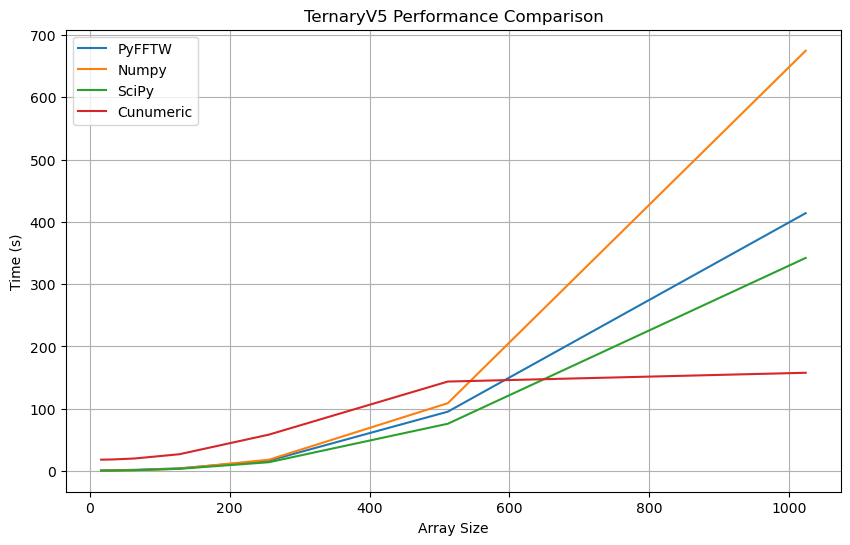

In [6]:
sizes = [16, 32, 64, 128, 256, 512, 1024]
NUM_ITER = 2000

# Measure time taken for each size
time_numpy = []
time_pyfftw = []
time_scipy = []
time_cunumeric = []

for size in tqdm(sizes):
    time_numpy.append(ternary_numpy(size, num_iter=NUM_ITER))
    time_pyfftw.append(ternary_pyfftw(size, num_iter=NUM_ITER))
    time_scipy.append(ternary_scipy(size, num_iter=NUM_ITER))
    time_cunumeric.append(ternary_cunumeric(size, num_iter=NUM_ITER))
    # print(f'size {size} done')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_pyfftw, label='PyFFTW')
plt.plot(sizes, time_numpy, label = 'Numpy')
plt.plot(sizes, time_scipy, label='SciPy')
plt.plot(sizes, time_cunumeric, label='Cunumeric')
plt.title('TernaryV5 Performance Comparison')
plt.xlabel('Array Size')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
print("Numpy:")
print(time_numpy)
print("PyFFTW:")
print(time_pyfftw)
print("SciPy:")
print(time_scipy)
print("Cunumeric:")
print(time_cunumeric)

Numpy:
[0.46660444000000023, 0.7551469080000004, 1.2947999219999957, 3.833439556000002, 18.09253301999999, 108.90717897500002, 674.705894853]
PyFFTW:
[1.0099516000000004, 1.172328041, 1.879901824000001, 4.245046293999991, 16.618279990000005, 95.24625191000001, 413.91956052499995]
SciPy:
[0.47417727300000045, 0.6994906629999988, 1.3245574680000018, 3.5079038819999937, 14.116704131999995, 75.88879753399999, 342.0617787780002]
Cunumeric:
[18.20130468, 18.528321058, 20.109230270000005, 26.945141897000013, 58.39914384800002, 143.60989727700007, 157.7097021049999]


In [9]:
ternary_cunumeric(256, num_iter=NUM_ITER)

58.542752371999995

In [1]:
time_numpy = [0.46660444000000023, 0.7551469080000004, 1.2947999219999957, 3.833439556000002, 18.09253301999999, 108.90717897500002, 674.705894853]
time_pyfftw = [1.0099516000000004, 1.172328041, 1.879901824000001, 4.245046293999991, 16.618279990000005, 95.24625191000001, 413.91956052499995]
time_scipy = [0.47417727300000045, 0.6994906629999988, 1.3245574680000018, 3.5079038819999937, 14.116704131999995, 75.88879753399999, 342.0617787780002]
time_cunumeric = [18.20130468, 18.528321058, 20.109230270000005, 26.945141897000013, 58.39914384800002, 143.60989727700007, 157.7097021049999]

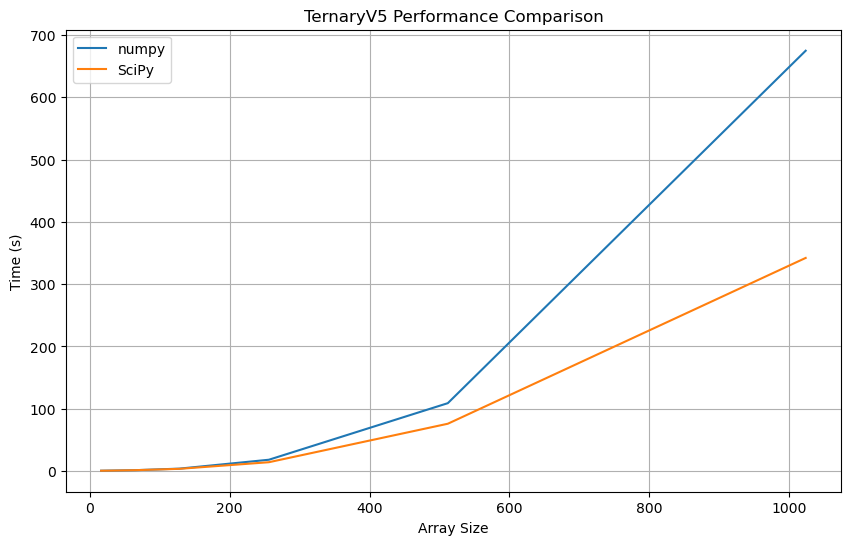

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(sizes, time_numpy, label='numpy')
plt.plot(sizes,time_pyfftw,label='pyfftw')
plt.plot(sizes, time_scipy, label='SciPy')
plt.plot(sizes, time_cunumeric, label='Cunumeric (Naive)')
plt.title('TernaryV5 Performance Comparison')
plt.xlabel('Array Size')
plt.ylabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Check the time taken for this part of the code
start_time = time("s")
Nx = 100
Ny = 100
dx = 1.0
dy = 1.0
kx = 2 * cu.pi * cu.fft.rfftfreq(Nx, d=dx)
ky = 2 * cu.pi * cu.fft.fftfreq(Ny, d=dy)
kx, ky = cu.meshgrid(kx, ky)
k2 = kx**2 + ky**2
k4 = k2**2
end_time = time("s")
print(f"Time taken : {end_time - start_time} s")

/tmp/ipykernel_1029301/2405761094.py:7: RuntimeWarning: cuNumeric has not implemented numpy.fft.rfftfreq and is falling back to canonical numpy. You may notice significantly decreased performance for this function call.
  kx = 2 * cu.pi * cu.fft.rfftfreq(Nx, d=dx)
/tmp/ipykernel_1029301/2405761094.py:8: RuntimeWarning: cuNumeric has not implemented numpy.fft.fftfreq and is falling back to canonical numpy. You may notice significantly decreased performance for this function call.
  ky = 2 * cu.pi * cu.fft.fftfreq(Ny, d=dy)
Time taken : 0.0020677470001828624 s


The above code doesn't take much time to execute. Most of the time is spent in the simulation loop.